In [94]:
import cv2 as cv
import numpy as np
from PIL import Image
import IPython
import pandas as pd
import matplotlib.pyplot as plt

In [95]:
def imshow(img):
    _, ret = cv.imencode('.jpg', img)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

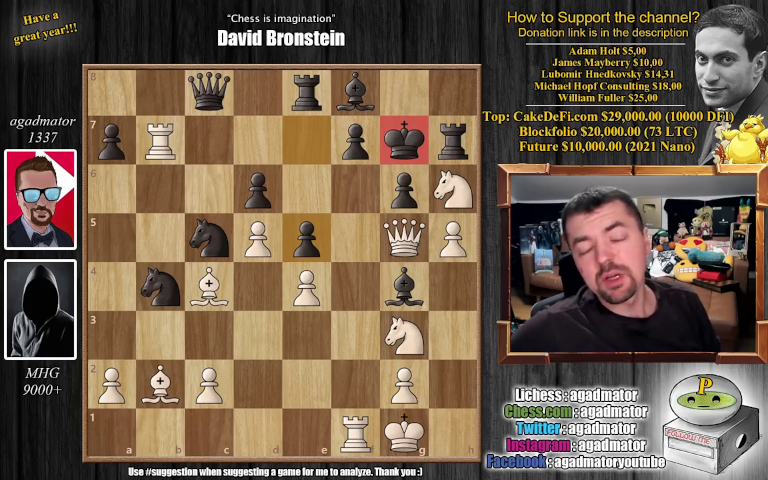

In [96]:
example_image = Image.open('../tests/test_images/agadmator_1.png')
display(example_image)

In [97]:
def gen_kernel(n):
    template = np.zeros((n, n), dtype=np.uint8)
    half_n = n // 2
    template[:half_n, :half_n] = 255
    template[half_n:, half_n:] = 255
    return template

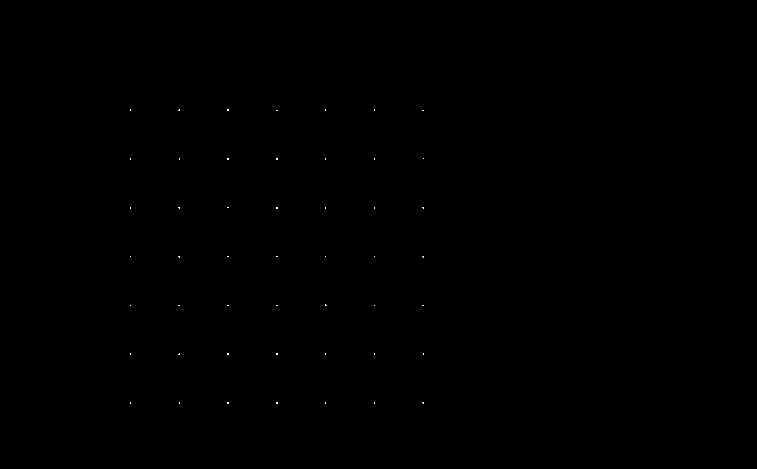

In [98]:
k_size = 12
kernel = gen_kernel(k_size)
img = np.array(example_image.convert('L'), dtype=np.uint8)
match_result = np.abs(cv.matchTemplate(img, kernel, cv.TM_CCOEFF_NORMED))
_, match_result = cv.threshold(match_result, .85, 1, cv.THRESH_BINARY)
imshow(match_result * 255)

In [99]:
match_result.max()

1.0

In [100]:
contours, hierarchy = cv.findContours(match_result.astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

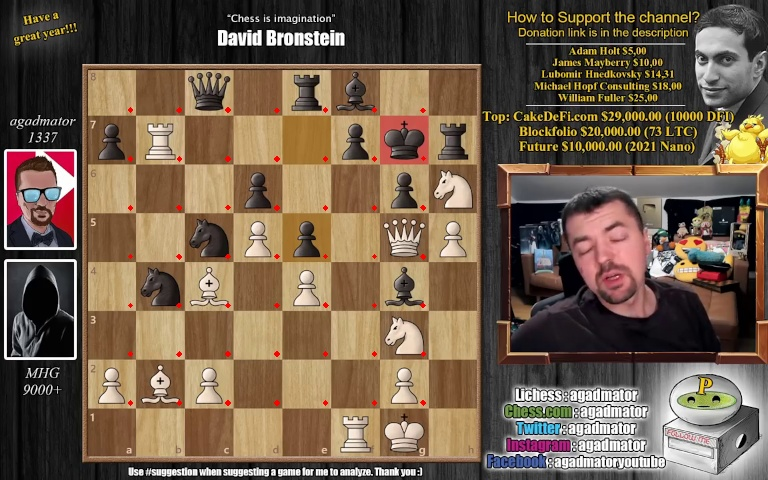

In [101]:
contoured_img = np.asarray(example_image).copy()
contoured_img = cv.cvtColor(contoured_img, cv.COLOR_RGB2BGR)
cv.drawContours(contoured_img, contours, -1, (0, 0, 255), 3)
imshow(contoured_img)

In [102]:
def centerOfContour(contour):
    try:
        M = cv.moments(contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return np.asarray([cX, cY], dtype=np.float32)
    except ZeroDivisionError:
        return np.mean(contour[:, 0, :], axis=0)

In [103]:
centers = np.array([centerOfContour(c) for c in contours])
centers += np.array([k_size//2, k_size//2])

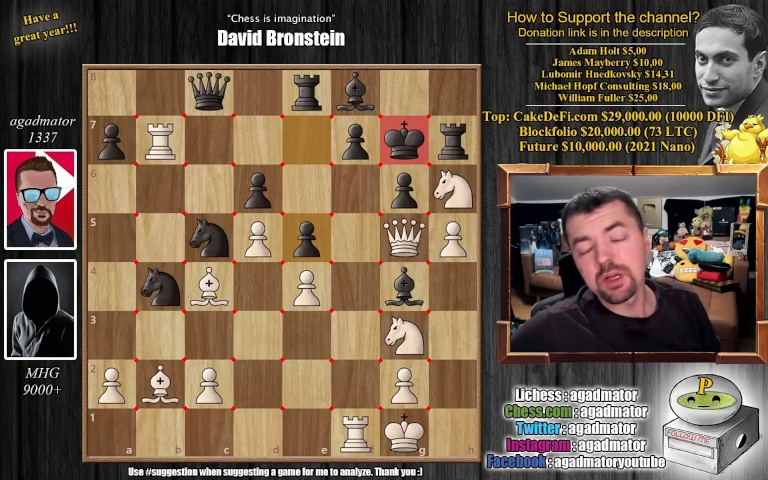

In [104]:
inner_corners_img = np.asarray(example_image).copy()
inner_corners_img = cv.cvtColor(inner_corners_img, cv.COLOR_RGB2BGR)
for c in centers:
    cv.circle(inner_corners_img, np.rint(c).astype(np.int32), 2, (0, 0, 255), -1)
imshow(inner_corners_img)

In [105]:
def centers_to_cb_corners(centers):
    centers_df = pd.DataFrame(centers, columns=['x', 'y']).round().astype(np.int32)
    value_counts_x = centers_df.x.value_counts()
    value_counts_y = centers_df.y.value_counts()

    columns = value_counts_x[value_counts_x > 2]
    rows = value_counts_y[value_counts_y > 2]
    
    l_col, r_col = columns.index.to_series().apply(['min', 'max'])
    t_row, b_row = rows.index.to_series().apply(['min', 'max'])
    
    inner_width = r_col - l_col
    inner_height = b_row - t_row
    square_width = inner_width / 6
    square_height = inner_height / 6
    l_col -= square_width
    r_col += square_width
    t_row -= square_height
    b_row += square_width
    return (np.array([l_col, t_row], dtype=np.int32), np.array([r_col, b_row], dtype=np.int32))

In [106]:
centers_to_cb_corners(centers)

(array([87, 67], dtype=int32), array([476, 456], dtype=int32))

In [107]:
centers_df = pd.DataFrame(centers, columns=['x', 'y'])
value_counts = centers_df.x.round().astype(np.int32).value_counts()
value_counts[value_counts > 2].index

Int64Index([380, 331, 282, 136, 428, 184, 233, 234], dtype='int64')

In [108]:
tl, br = centers_to_cb_corners(centers)
tl, br

(array([87, 67], dtype=int32), array([476, 456], dtype=int32))

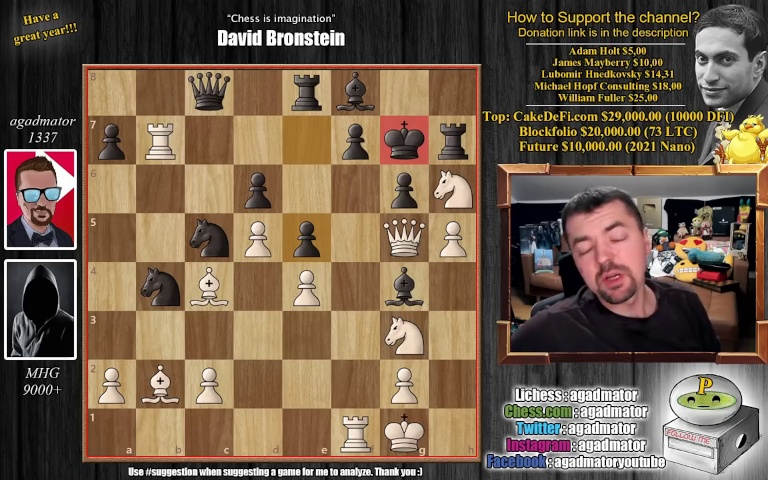

In [109]:
cb_outline_img = np.asarray(example_image).copy()
cb_outline_img = cv.cvtColor(cb_outline_img, cv.COLOR_RGB2BGR)
cv.rectangle(cb_outline_img, tl, br, (0, 0, 255), 1)
imshow(cb_outline_img)